# Machine Learning Engineer Nanodegree

## Capstone Project

## Project: Write an Algorithm for Distracted Driver Detection 

---



>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.



---

### The Road Ahead

The notebook is broken into separate steps as shown below.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Create and train a CNN to Classify Driver Images (from Scratch)
* [Step 2](#step3): Train a CNN with Transfer Learning (Using Fine-tuned VGG16)
* [Step 3](#step4): Kaggle Results




In [55]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

import keras
import numpy
from keras.preprocessing.image import ImageDataGenerator

In [56]:
import keras
import numpy
from keras.preprocessing.image import ImageDataGenerator

<a id="step0"></a>
## Step 0: Import Datasets

### Import Driver Dataset

In the following code cell, we create a instance of ImageDataGenerator which does all preprocessing operations on images that we are going to feed to our CNN

In [57]:
train_datagen = ImageDataGenerator(
        rescale=1./255, validation_split=0.2)
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True)


In the following code, we are loading only 32 images at once into memory and performing all the preprocessing operations on loaded images. The flow_from_directory loads a defined set of images from the location of images, instead of loading all images at once into memory.

- train_generator contains training set
- val_generator contains validation set

In [58]:
train_data = '../input/state-farm-distracted-driver-detection/train'
test_data = '../input/state-farm-distracted-driver-detection/test'
train_generator = train_datagen.flow_from_directory(
        train_data,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='training')

val_generator = train_datagen.flow_from_directory(
        train_data,
        target_size=(224,224),
        batch_size=32,
        class_mode='categorical',
        subset='validation')


Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [59]:
from PIL import Image

ac_labels=  ["c0: safe driving",
"c1: texting - right",
"c2: talking on the phone - right",
"c3: texting - left",
"c4: talking on the phone - left",
"c5: operating the radio",
"c6: drinking",
"c7: reaching behind",
"c8: hair and makeup",
"c9: talking to passenger"]


In [60]:
imgs, labels = next(train_generator)

## Dataset Exploration
- Following code block explores and reveals the dataset

In [61]:
import functools

def list_counts(start_dir):
    lst = sorted(os.listdir(start_dir))
    out = [(fil, len(os.listdir( os.path.join(start_dir, fil)))) for fil in lst if os.path.isdir(os.path.join(start_dir,fil))]
    return out

out = list_counts(train_data)
labels, counts = zip(*out)
print("Total number of images : ",functools.reduce(lambda a,b : a+b, counts))
out

Total number of images :  22424


[('c0', 2489),
 ('c1', 2267),
 ('c2', 2317),
 ('c3', 2346),
 ('c4', 2326),
 ('c5', 2312),
 ('c6', 2325),
 ('c7', 2002),
 ('c8', 1911),
 ('c9', 2129)]

## Data Visualization
Following code block. displays images and their respective labels of training/ validation dataset

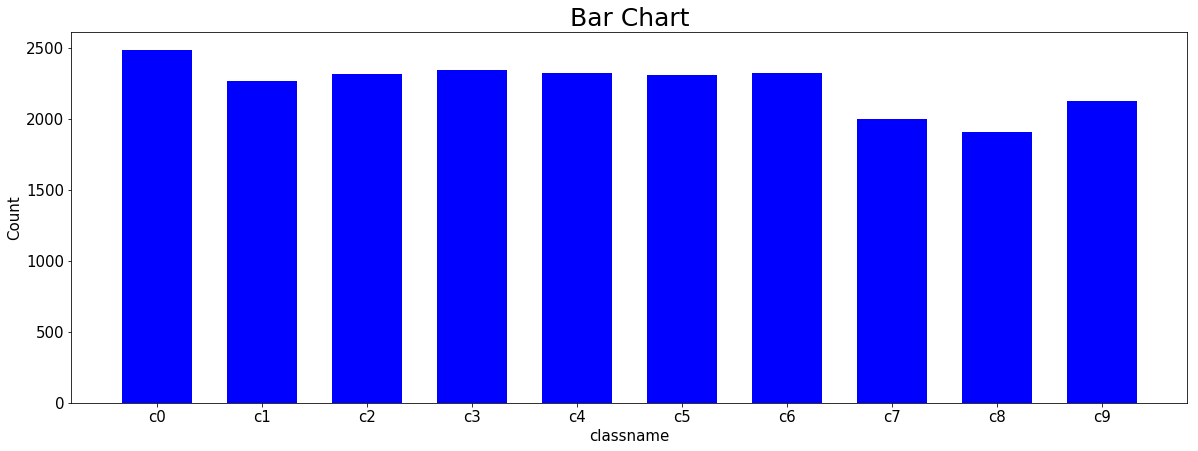

Label :  c0: safe driving


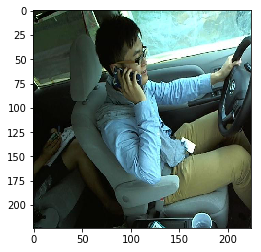

In [97]:

import matplotlib.pyplot as plt
import pandas as pd
# Pretty display for notebooks
%matplotlib inline


y = np.array(counts)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="blue")

plt.title('Bar Chart',size=25)
plt.xlabel('classname',size=15)
plt.ylabel('Count',size=15)

plt.show()



def showImages(imgs ,inlabels=None, single=True):
    if single:
        aim = (imgs * 255 ).astype(np.uint8)
        img = Image.fromarray(aim)
        if labels is not None:
            print("Label : ", ac_labels[np.argmax(inlabels)])
        plt.imshow(img)
        plt.show()
    else:
        for i,img in enumerate(imgs):
            lbl = None
            if inlabels is not None:
                lbl = labels[i]
            showImages(img, lbl)

ind = 1
showImages(imgs[:ind], inlabels=labels[:ind], single = False)


---
<a id='step1'></a>
## Step 1: Create a CNN to Classify Driver Images (from Scratch)



A CNN is created to classify driver images.  At the end of the code cell block, the layers of the model are summarized by executing the line:
    
        model.summary()

We have created 6 convolutional layers with 1 max pooling layer and 1 GlobalAveragePooling in between. Filters were increased from 8 to 512 in total convolutional layers. Also dropout was used along with Global average pooling layer before using the fully connected layer. Number of nodes in the last fully connected layer were setup as 10 along with softmax activation function. ReLU activation function was used for all other layers.

6 convolutional layers were used to learn hierarchy of high level features. Max pooling layer is added to reduce the dimensionality. Global Average Pooling layer is added to reduce the dimensionality as well as the matrix to row vector. This is because fully connected layer only accepts row vector. Dropout layers were added to reduce overfitting and ensure that the network generalizes well. The last fully connected layer with softmax activation function is added to obtain probabilities of the prediction.


In [63]:
from keras.layers import ZeroPadding2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.layers import GlobalAveragePooling2D, MaxPooling2D
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras import regularizers

In [64]:
input_layer = Input(shape=(224,224, 3))

conv = Conv2D(filters=8, kernel_size=2)(input_layer)
conv = Conv2D(filters=16, kernel_size=2, activation='relu')(conv)
conv = Conv2D(filters=32, kernel_size=2, activation='relu')(conv)
conv = MaxPooling2D()(conv)

conv = Conv2D(filters=64, kernel_size=2, activation='relu')(conv)
conv = Conv2D(filters=128, kernel_size=2, activation='relu')(conv)
conv = Conv2D(filters=512, kernel_size=2, activation='relu')(conv)

conv = GlobalAveragePooling2D()(conv)
dense = Dense(units=500, activation='relu')(conv)
dense = Dropout(0.1)(dense)
dense = Dense(units=100, activation='relu')(dense)
dense = Dropout(0.1)(dense)
output = Dense(units=10, activation='softmax')(dense)

model = Model(inputs=input_layer, outputs = output)

In [65]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 223, 223, 8)       104       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 222, 222, 16)      528       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 221, 221, 32)      2080      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 109, 109, 64)      8256      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 108, 108, 128)     32896     
__________

### Compile CNN from scratch Model

In [66]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

The model is trained in the code cell below. Model checkpointing is used to save the model that attains the best validation loss.


In [67]:
#model.load_weights('best_model_1.hdf5')
checkpoint = ModelCheckpoint('best_model_1.hdf5', save_best_only=True, verbose=1)

history = model.fit_generator(train_generator, steps_per_epoch=len(train_generator),
                    epochs=10,
                   validation_data = val_generator,
                   validation_steps=len(val_generator),
                    callbacks=[checkpoint] )

- In the following code block, we are plotting the loss value of training and validation to see whether the model is learning or not

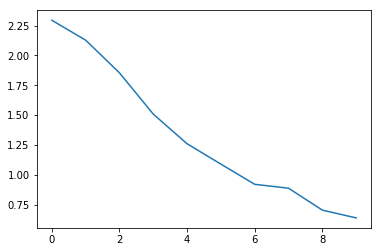

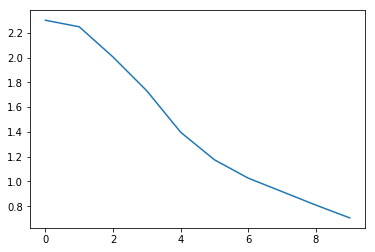

In [68]:
plt.plot(history.history['val_loss'])
plt.show()
plt.plot(history.history['loss'])

#### Loading test dataset into memory and predict on test images
- Following code block contains a method, that loads all test images into memory by batches, each batch with 32 images when it is called each time

In [69]:

!ls ../input/state-farm-distracted-driver-detection/
import os
# model.load_weights('../input/best_model_1.hdf5')
#Test Images
batch_index = 0
files_list = os.listdir("../input/state-farm-distracted-driver-detection/test/")
def load_test_images(batch_size=32, src='../input/state-farm-distracted-driver-detection/test/'):
    global batch_index, files_list
    imgs_list = files_list[batch_index: batch_index+batch_size]
    batch_index += len(imgs_list)
    batch_imgs = []
    for img_name in imgs_list:
        img = Image.open(src+img_name)
        im = img.resize((224,224))
        batch_imgs.append(np.array(im)/255.)
#     plt.imshow()
#     plt.show()
    return np.array(batch_imgs)


driver_imgs_list.csv  sample_submission.csv  test  train


- Following code block predicts on test images by loading 32 images a batch using load_test_images function

In [70]:
#Test Images write
import sys
preds_list = np.array([])
batch_index=0
batch_size = 32
while True:
    tst_imgs = load_test_images(batch_size=batch_size)
    if(tst_imgs.shape[0] <= 0  ):
        print("Batchsize is less : ",batch_index)
        break
    preds = model.predict(tst_imgs)
    print("\r {},  batch_size : {}, nth_batch/all_batch : {}/{}".format(preds_list.shape,batch_size, batch_index, len(files_list)),end="")    
    sys.stdout.flush()
    if len(preds_list) == 0:
        preds_list = np.array(preds)
    else:
        preds_list = np.append(preds_list, preds, axis=0)


 (79712, 10),  batch_size : 32, nth_batch/all_batch : 79726/79726Batchsize is less :  79726


## Convert the predicted output to submittable output file

In [72]:
titles = "img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9".split(",")
names = pd.DataFrame(files_list[:len(preds_list)])
names.columns=["img"]
df = pd.DataFrame(preds_list)
df.columns=titles[1:]
df['img']=names['img']
df = df[titles]
df.tail()
df.to_csv('sub.csv',index=False)


## Predictions by scratch CNN on some sample images
- Seems like the predictions are not so accurate because of less training

label :  c3: texting - left


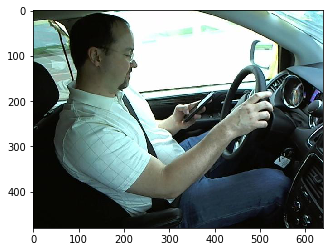

label :  c0: safe driving


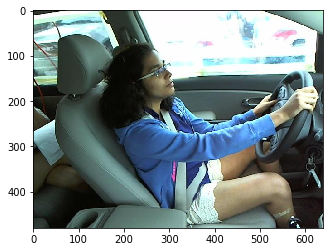

In [98]:
indices = [1,24]
for index in indices:
#     display(df.iloc[index])
    cls = np.argmax(list(df.iloc[index][1:]))
    print("label : ",ac_labels[cls])
    im_test = Image.open('../input/state-farm-distracted-driver-detection/test/'+df.iloc[index]['img'])
    plt.imshow(np.array(im_test))
    plt.show()

---
<a id="step2"></a>
##  Step 2: Train a CNN with Transfer Learning (Using Fine-tuned VGG16 Model)

- In the following steps, we are going to load a VGG16 model, without top Fully connected layers, with its trained weights
- Then we are going add Fully Connected Layers on top of GlobalAveragePooling layer with Dropout layers in between
- The following code block contains a method load_VGG16, which loads VGG16 model with weights loaded when weights file location is given

In [ ]:

def load_VGG16(weights_path=None, no_top=True):

    input_shape = (224, 224, 3)

    #Instantiate an empty model
    img_input = Input(shape=input_shape)   # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    x = GlobalAveragePooling2D()(x)
    vmodel = Model(img_input, x, name='vgg16')
    if weights_path is not None:
        print("Weights have been loaded.")
        vmodel.load_weights(weights_path)

    return vmodel


- In the following code block, we have added 3 Dense layers with dropout layers on top of VGG16 CNN model.

In [84]:
vgg_model_raw = load_VGG16('../input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg_model = vgg_model_raw.output
#vgg_model = Flatten()(vgg_model)
vgg_model = Dense(5000, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(vgg_model)
#vgg_model = Dropout(0.1)(vgg_model)
#vgg_model = Dense(1000, activation='relu')(vgg_model)
vgg_model = Dropout(0.1)(vgg_model)
vgg_model = Dense(500, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(vgg_model)
vgg_model = Dropout(0.1)(vgg_model)
vgg_model = Dense(10, activation='softmax')(vgg_model)
vgg_m = Model(inputs=vgg_model_raw.input, outputs= vgg_model)

Weights have been loaded.


In [85]:
vgg_m.layers[16].get_weights()

[array([[[[-1.12610648e-03, -1.39102731e-02, -4.15291899e-04, ...,
           -2.39090272e-03,  5.59418183e-03, -1.67810004e-02],
          [ 1.13813886e-02, -6.83033955e-04, -8.76976922e-03, ...,
           -8.44151899e-03, -3.70610040e-03,  1.24894250e-02],
          [ 2.18971120e-03,  1.76711346e-03,  1.23967733e-02, ...,
            1.34555586e-02,  1.07239345e-02,  5.72480168e-03],
          ...,
          [-8.70769471e-03,  4.26163105e-03, -7.06244586e-03, ...,
            1.54851489e-02,  4.63837199e-03,  7.84500409e-03],
          [-6.56485325e-04,  7.68889068e-03, -1.45298289e-03, ...,
           -7.35005224e-03, -3.10419098e-04,  8.47741403e-03],
          [ 5.95664885e-03, -3.27580003e-03, -5.32116368e-03, ...,
           -2.03936966e-03,  1.35865889e-03,  5.91904763e-03]],
 
         [[ 2.12769513e-03, -5.14811045e-03, -5.62243350e-03, ...,
           -1.31134260e-02,  4.88865655e-03, -1.01500070e-02],
          [ 1.17016789e-02, -7.15120370e-03, -8.39244854e-03, ...,
     

### Compile the vgg16 model with categorical crossentropy as loss function and SGD as optimizer

In [86]:
vgg_m.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(0.001), metrics=['accuracy'])


In [96]:
vgg_m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

- Create a Checkpoint to save best weights, when loss in improvised
- Train the model for 6 epochs

In [87]:

checkpoint = ModelCheckpoint('vgg_model.h5', save_best_only=True, verbose=1)

history = vgg_m.fit_generator(train_generator, steps_per_epoch=len(train_generator),
                   epochs=6,
                   validation_data = val_generator,
                   validation_steps=len(val_generator),
                   callbacks=[checkpoint] )



Epoch 1/10
561/561 [==============================] - 174s 311ms/step - loss: 2.2954 - acc: 0.1524 - val_loss: 2.2105 - val_acc: 0.3510

Epoch 00001: val_loss improved from inf to 2.21053, saving model to vgg_model.h5
Epoch 2/10
561/561 [==============================] - 172s 307ms/step - loss: 1.4734 - acc: 0.5169 - val_loss: 0.5128 - val_acc: 0.8467

Epoch 00002: val_loss improved from 2.21053 to 0.51282, saving model to vgg_model.h5
Epoch 3/10
561/561 [==============================] - 173s 308ms/step - loss: 0.4154 - acc: 0.8759 - val_loss: 0.2165 - val_acc: 0.9496

Epoch 00003: val_loss improved from 0.51282 to 0.21648, saving model to vgg_model.h5
Epoch 4/10
561/561 [==============================] - 173s 309ms/step - loss: 0.2005 - acc: 0.9461 - val_loss: 0.2178 - val_acc: 0.9259

Epoch 00004: val_loss did not improve from 0.21648
Epoch 5/10
561/561 [==============================] - 178s 318ms/step - loss: 0.1370 - acc: 0.9669 - val_loss: 0.1014 - val_acc: 0.9719

Epoch 00005: 

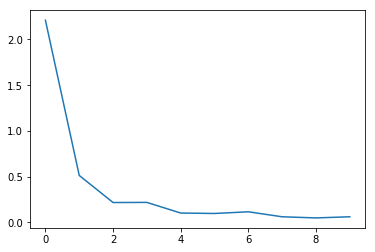

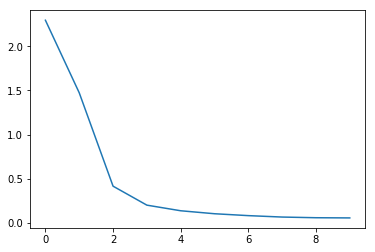

In [88]:
plt.plot(history.history['val_loss'])
plt.show()
plt.plot(history.history['loss'])

- Following method gives a batch of 32 images at each call, just like a generator

In [95]:
!ls
import os
#model.load_weights('../input/best_model_1.hdf5')
#Test Images
batch_index = 0
#files_lst = os.listdir("../input/state-farm-distracted-driver-detection/test")
files_list = os.listdir("../input/state-farm-distracted-driver-detection/test")
def load_test_images(batch_size=32, src='../input/state-farm-distracted-driver-detection/test/'):
    global batch_index, files_list
    imgs_list = files_list[batch_index: batch_index+batch_size]
    batch_index += len(imgs_list)
    batch_imgs = []
    for img_name in imgs_list:
        img = Image.open(src+img_name)
        im = img.resize((224,224))
        batch_imgs.append(np.array(im)/255.)
#     plt.imshow()
#     plt.show()
    return np.array(batch_imgs)


__notebook_source__.ipynb  sub.csv	  vgg_model.h5
best_model_1.hdf5	   sub_VGG16.csv


In [90]:
#Test Images write
import sys
preds_list = np.array([])
batch_index=0
batch_size = 32

mm_raw = load_VGG16()

mm_model = mm_raw.output
mm_model = Dense(5000, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(mm_model)
mm_model = Dropout(0.1)(mm_model)
mm_model = Dense(500, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(mm_model)
mm_model = Dropout(0.1)(mm_model)
mm_model = Dense(10, activation='softmax')(mm_model)
mm = Model(inputs=vgg_model_raw.input, outputs= vgg_model)

mm.load_weights('vgg_model.h5')



while True:
    tst_imgs = load_test_images(batch_size=batch_size)
    if(tst_imgs.shape[0] <= 0  ):
        print("Batchsize is less : ",batch_index)
        break
    preds = mm.predict(tst_imgs)
    print("\r {},  batch_size : {}, nth_batch/all_batch : {}/{}".format(preds_list.shape,batch_size, batch_index, len(files_list)),end="")    
    sys.stdout.flush()
    if len(preds_list) == 0:
        preds_list = np.array(preds)
    else:
        preds_list = np.append(preds_list, preds, axis=0)


 (79712, 10),  batch_size : 32, nth_batch/all_batch : 79726/79726Batchsize is less :  79726


In [91]:

titles = "img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9".split(",")
names = pd.DataFrame(files_list[:len(preds_list)])
names.columns=["img"]
df = pd.DataFrame(preds_list)
df.columns=titles[1:]
df['img']=names['img']
df = df[titles]
df.tail()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
79721,img_81403.jpg,1.218325e-03,1.441570e-02,7.493971e-04,4.625941e-05,0.001232,6.114251e-04,7.402216e-01,4.640487e-03,0.236640,0.000225
79722,img_70945.jpg,1.833386e-06,2.421310e-05,9.285472e-01,1.024524e-06,0.000002,2.418677e-05,6.140463e-02,1.653827e-05,0.009945,0.000033
79723,img_64671.jpg,1.240088e-06,5.816725e-09,7.917059e-10,9.977575e-01,0.000128,3.904134e-05,1.657247e-07,2.257729e-08,0.000957,0.001118
79724,img_79635.jpg,1.797631e-09,1.415589e-09,6.381236e-06,8.032346e-10,0.000003,1.973888e-07,1.204941e-07,3.375907e-06,0.999593,0.000394
79725,img_23734.jpg,1.801756e-04,1.769028e-08,8.225616e-05,5.770857e-06,0.998957,6.615232e-05,3.718608e-06,3.636029e-10,0.000703,0.000002


In [92]:
df.to_csv('sub_VGG16.csv',index=False)

label :  c3: texting - left


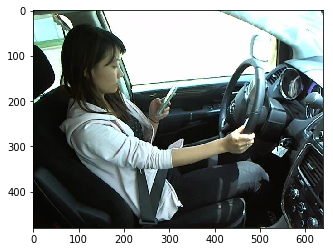

label :  c0: safe driving


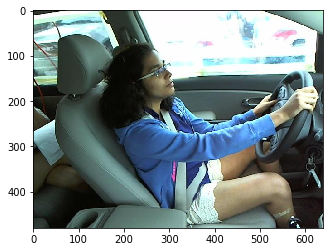

In [99]:
indices = [10,24]
for index in indices:
#     display(df.iloc[index])
    cls = np.argmax(list(df.iloc[index][1:]))
    print("label : ",ac_labels[cls])
    im_test = Image.open('../input/state-farm-distracted-driver-detection/test/'+df.iloc[index]['img'])
    plt.imshow(np.array(im_test))
    plt.show()


In [94]:
!cat sub_VGG16.csv | head -10

img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
img_53062.jpg,7.96198e-08,7.69732e-07,0.0002969814,1.8971305e-07,1.6085252e-07,6.0376965e-06,0.9891205,1.0475115e-06,0.010572449,1.8415653e-06
img_56784.jpg,0.000652816,4.8249727e-05,2.1772445e-07,0.9983047,4.8036418e-05,2.3085036e-05,2.241854e-06,3.722179e-07,4.366197e-05,0.00087650545
img_66669.jpg,1.47472565e-05,2.3445074e-10,1.3979374e-08,5.175266e-05,0.99966156,3.3225623e-07,2.6837915e-07,6.1505495e-10,1.4016027e-05,0.00025737548
img_90863.jpg,5.8082653e-05,2.67076e-06,2.2830425e-05,1.1052223e-06,3.6727417e-07,0.056531213,0.0010649889,0.0027469478,0.2406502,0.6989216
img_84366.jpg,0.989805,0.0022343483,2.4934407e-06,9.197264e-06,0.000922217,0.00012293932,7.564641e-06,1.8233139e-07,0.000734433,0.006161748
img_50632.jpg,0.84763396,0.00030406407,3.6687359e-06,2.5506031e-05,0.00028285492,0.0021165037,6.0071943e-06,3.356691e-05,0.00023257073,0.14936131
img_72077.jpg,0.0008147313,3.1139568e-06,4.9094535e-07,3.2262327e-05,9.377401e-06,0.00025143617,3.348